In [1]:
from __future__ import print_function
import morphs

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pair_df = morphs.load.pop_pair_df()
morphs.data.parse.morph_dim(pair_df)

In [3]:
equal_spacing = pair_df.groupby("block_path").apply(
    lambda path_group: np.all(
        path_group.groupby("morph_dim").apply(
            lambda group: len(group["lesser_morph_pos"].unique()) < 10
        )
    )
)

In [4]:
from statsmodels.formula.api import ols

In [5]:
def categorical(group, spect_dist_control=False):
    sampled_points = group["lesser_morph_pos"].unique()
    boundaries = (sampled_points[:-1] + sampled_points[1:]) / 2.0
    intercepts = np.zeros(boundaries.shape)
    cis = np.zeros([2, boundaries.shape[0]])
    for i, boundary in enumerate(boundaries):
        group["contains_midpoint"] = (group["greater_morph_pos"] > boundary) & (
            boundary > group["lesser_morph_pos"]
        )
        if spect_dist_control:
            formula = (
                "red_neural_cosine_dist ~ spect_euclidean_dist + C(contains_midpoint)"
            )
        else:
            formula = "red_neural_cosine_dist ~ C(contains_midpoint)"
        lm = ols(formula, data=group)
        fit = lm.fit()
        intercepts[i] = fit.params.loc["C(contains_midpoint)[T.True]"]
        cis[:, i] = fit.conf_int().loc["C(contains_midpoint)[T.True]"].values
    return sampled_points, intercepts, cis

In [6]:
cat_df = pair_df.groupby(["block_path", "morph_dim"]).apply(categorical)

In [7]:
cat_df = cat_df.to_frame().reset_index()
morphs.data.parse.morph_dim(cat_df)
cat_df["bird_id"] = cat_df["block_path"].map(morphs.data.parse.bird_id)
cat_df["equal_spacing"] = cat_df["block_path"].map(equal_spacing)

In [8]:
def cat_viz(cat_df, **kwargs):
    all_birds = list(set(cat_df["bird_id"].unique()) | set(morphs.subj.BEHAVE_SUBJS))
    colors = sns.color_palette("husl", len(all_birds))
    color_dict = {subj: color for subj, color in zip(all_birds, colors)}
    g = morphs.plot.morph_grid(
        cat_df,
        _cat_viz,
        "Categoricality",
        map_kwargs={
            "color_dict": color_dict,
        },
        **kwargs
    )
    g.set(yticks=[])
    return g


def _cat_viz(color_dict, scale=True, softmax=True, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    morph_dim = data["morph_dim"].values[0]
    for index, row in data.iterrows():
        subj = row["bird_id"]
        sampled_points, intercepts, cis = row[0]
        x = sampled_points.repeat(2)[1:-1]
        y = intercepts.repeat(2)
        cis_y = cis.repeat(2, axis=1)
        if scale:
            scale_factor = np.max(np.abs(y))
            y /= scale_factor
            cis_y /= scale_factor
        if softmax:
            scale_factor = np.sum(np.exp(y))
            y = np.exp(y) / scale_factor
            cis_y = np.exp(cis_y) / scale_factor
        ax.plot(x, y, color=color_dict[subj], label=subj)
        ax.fill_between(x, cis_y[0, :], cis_y[1, :], color=color_dict[subj], alpha=0.25)
    morphs.plot.boundary(ax, morph_dim, color_dict=color_dict)

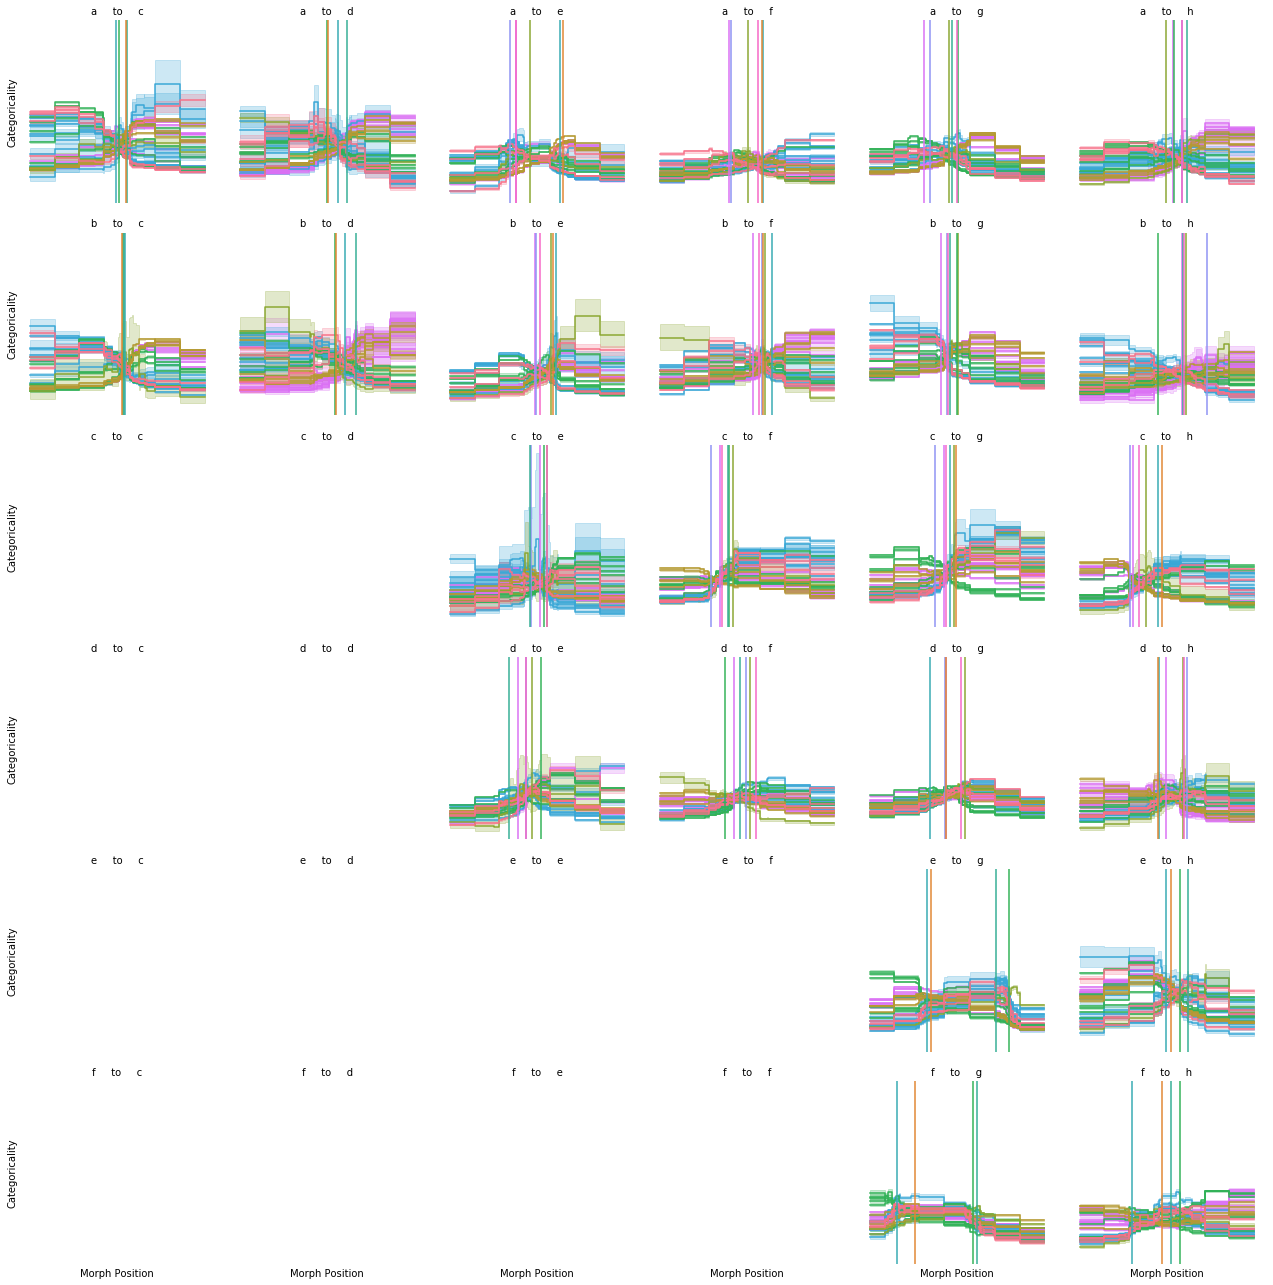

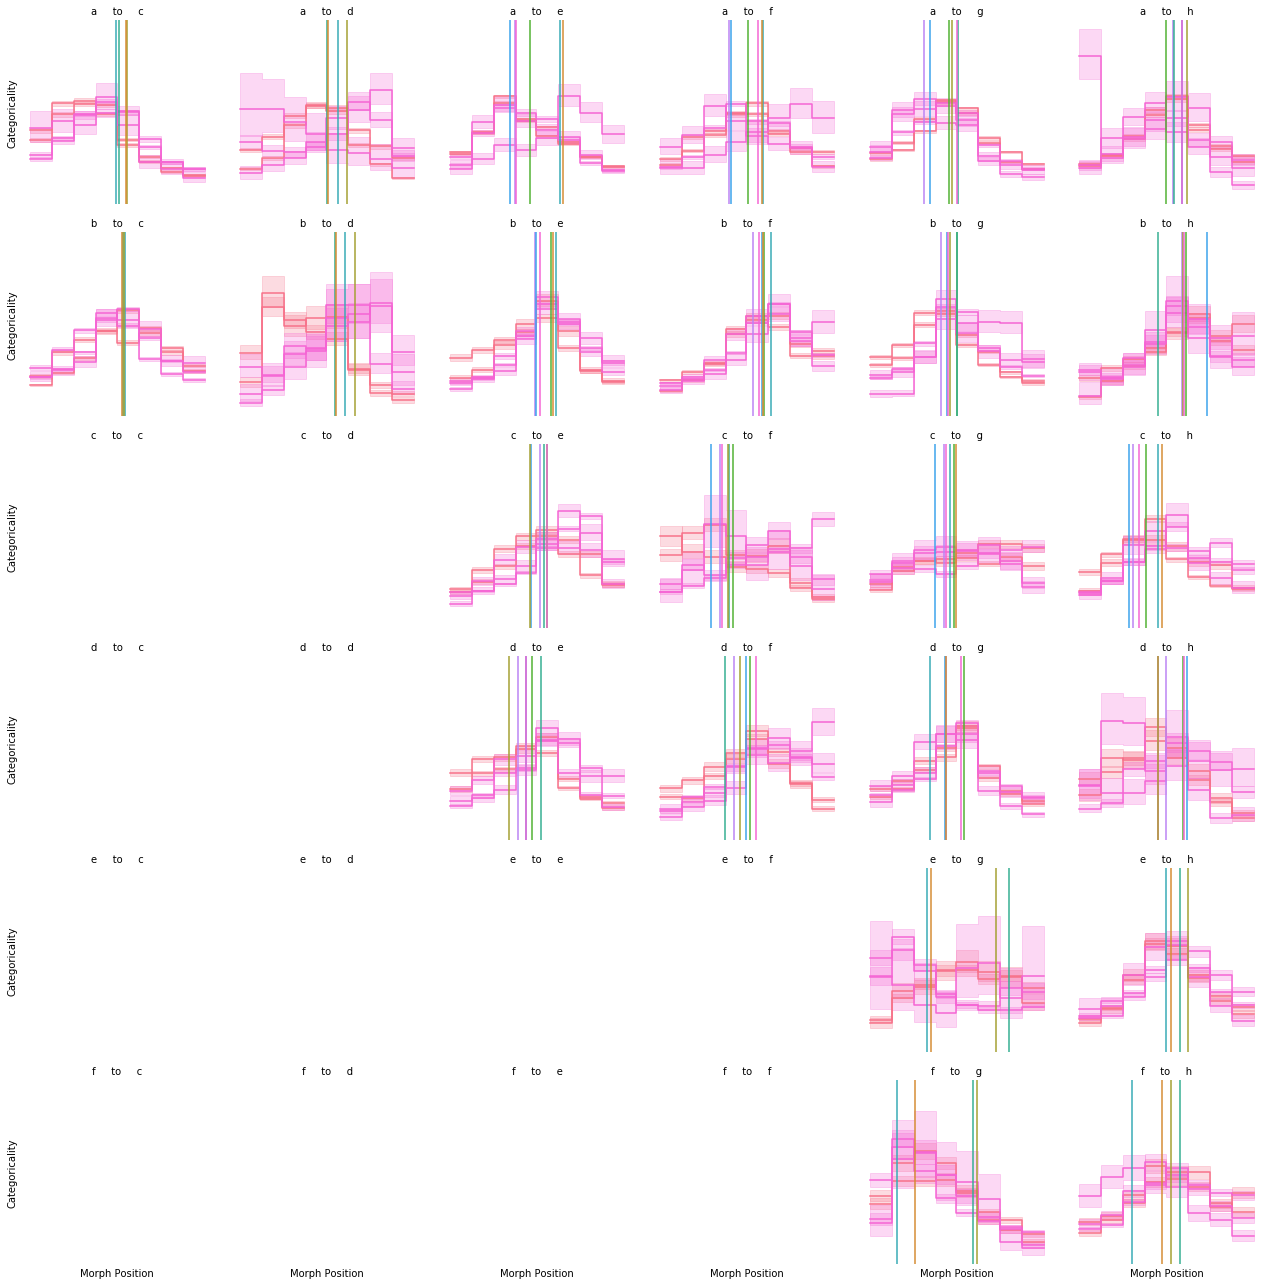

In [9]:
for spacing, spacing_group in cat_df.groupby("equal_spacing"):
    g = cat_viz(spacing_group)

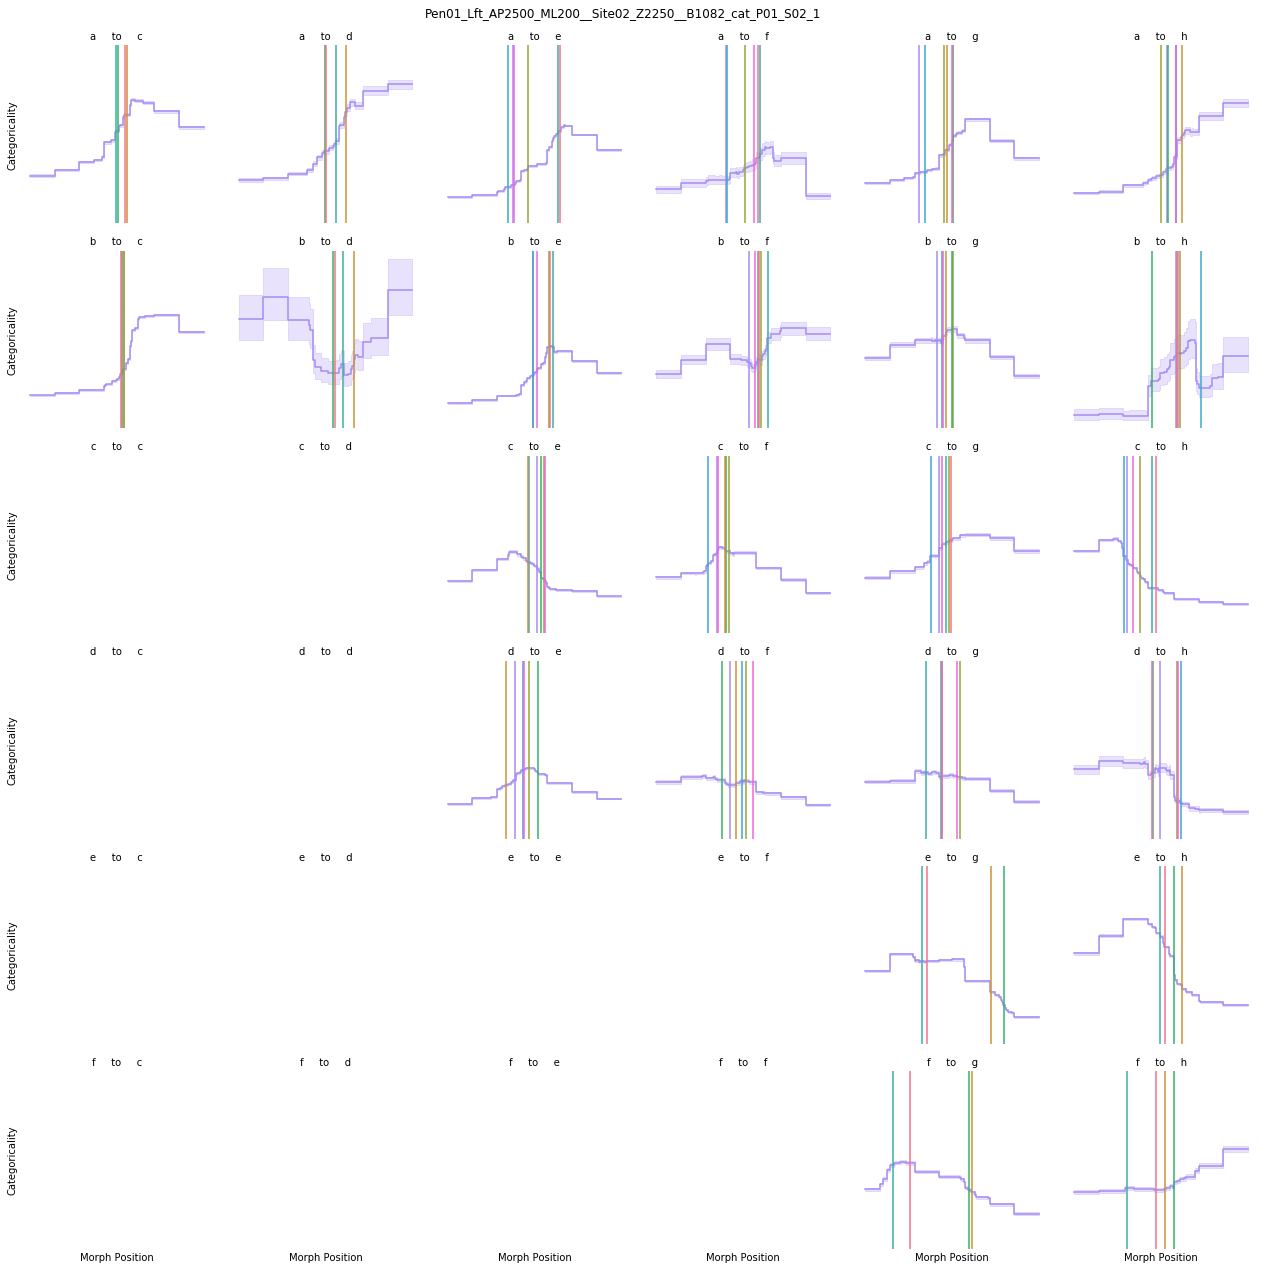

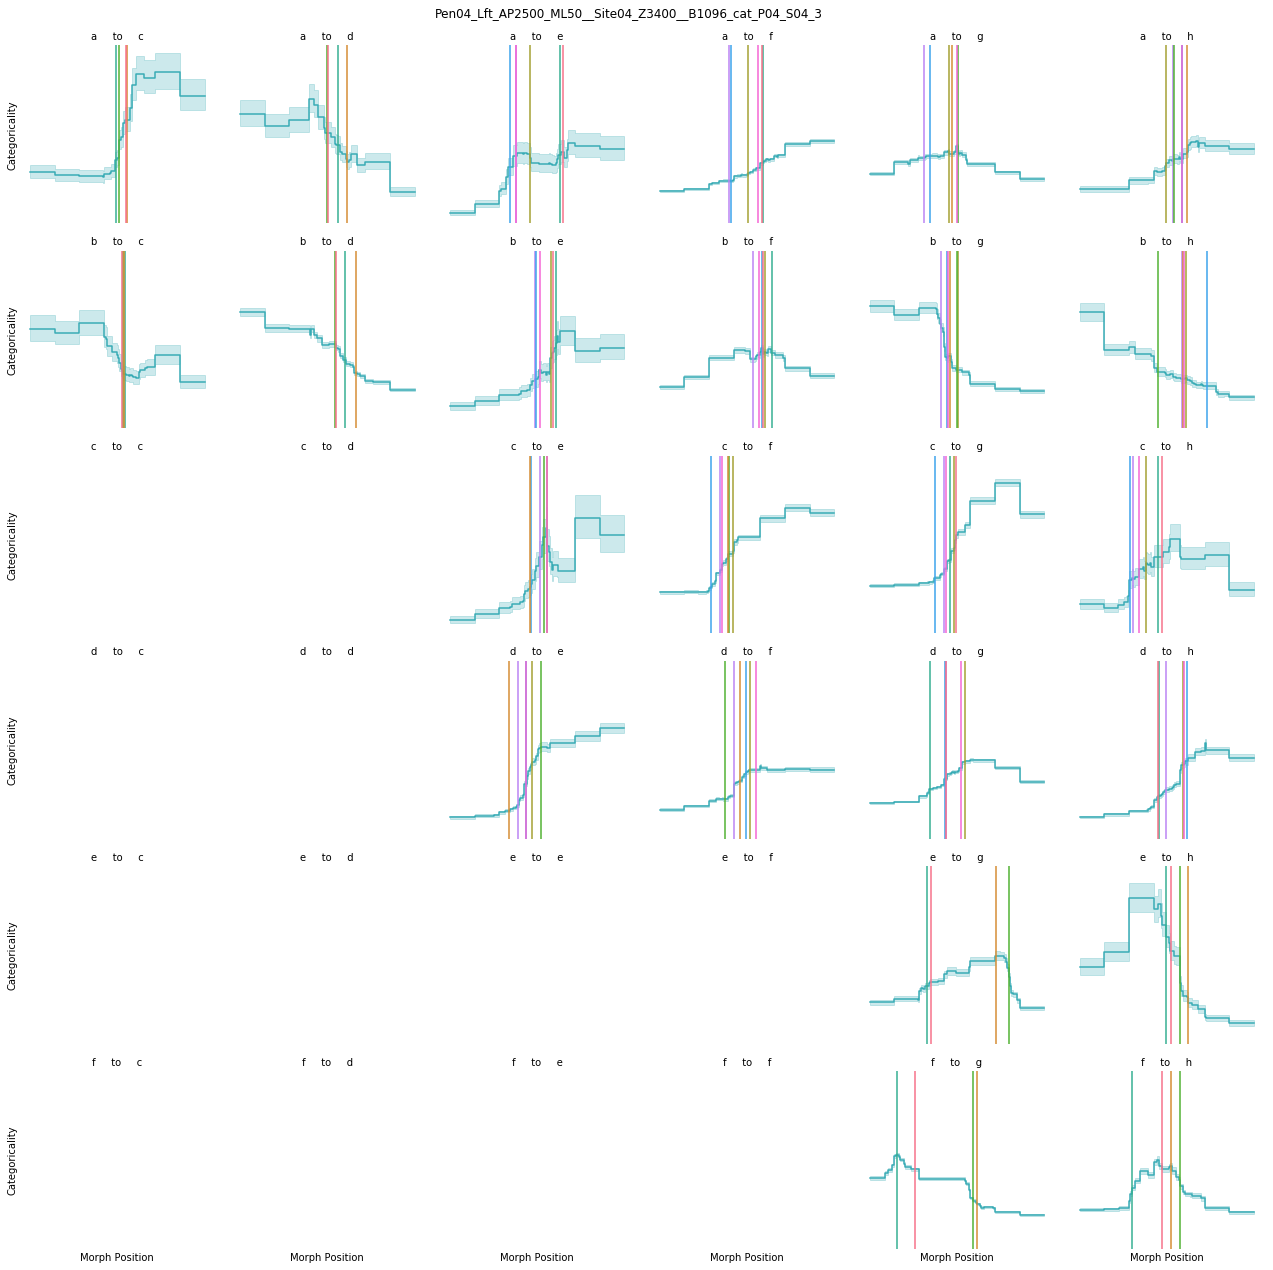

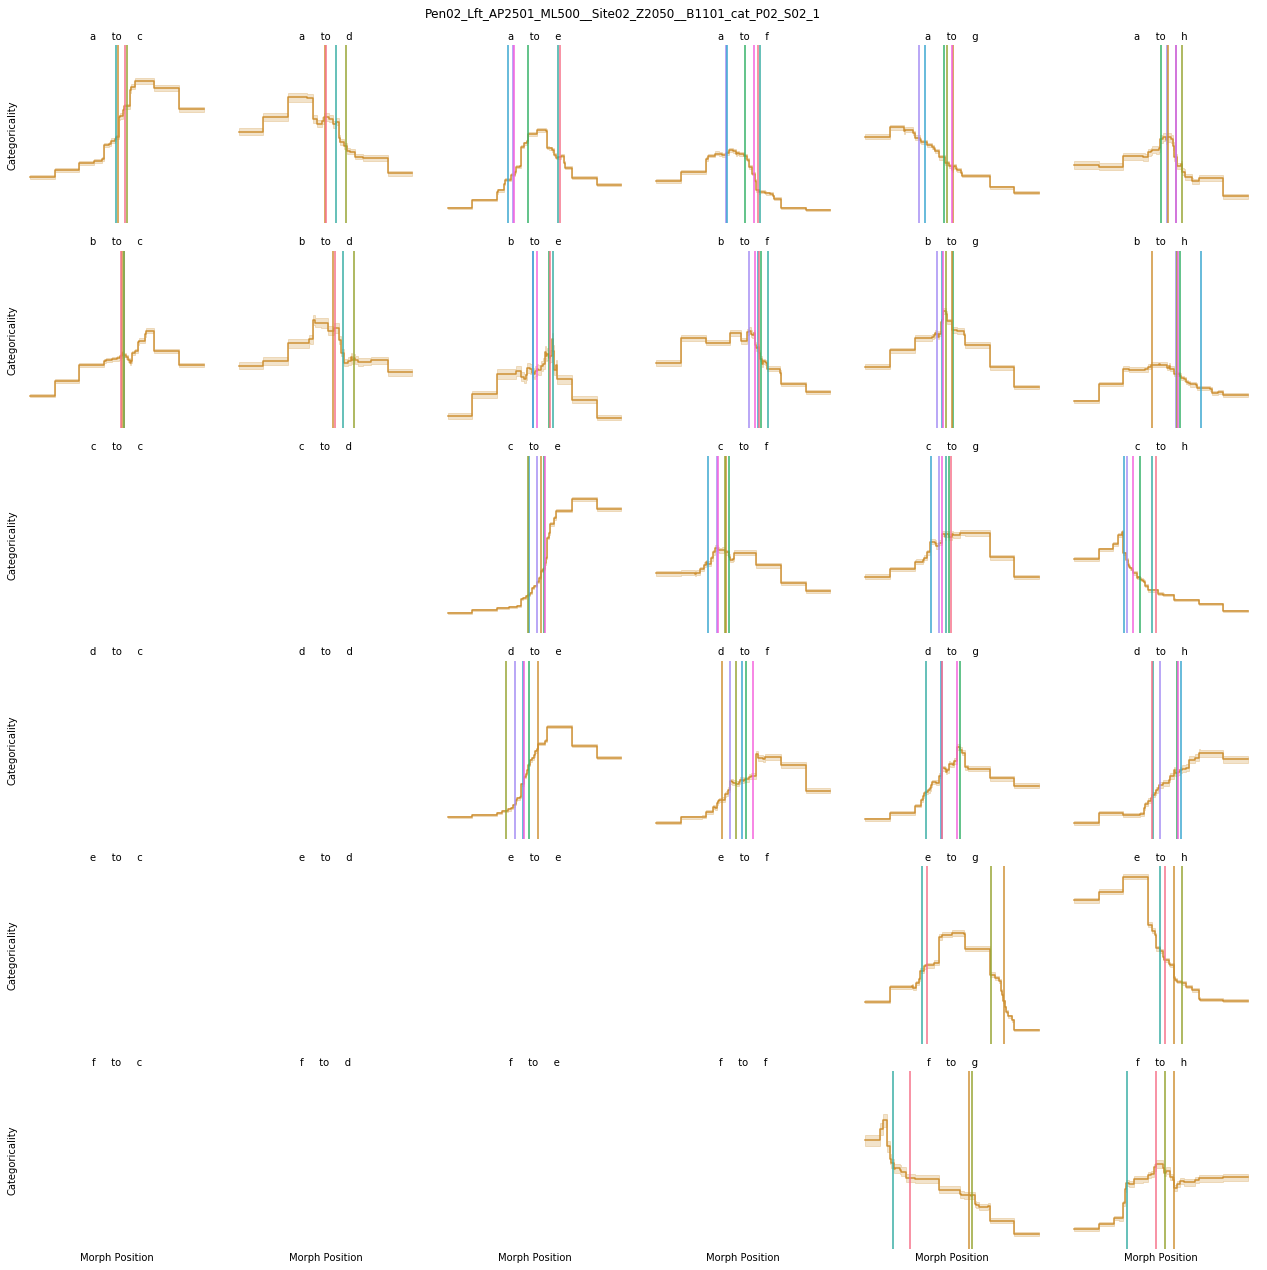

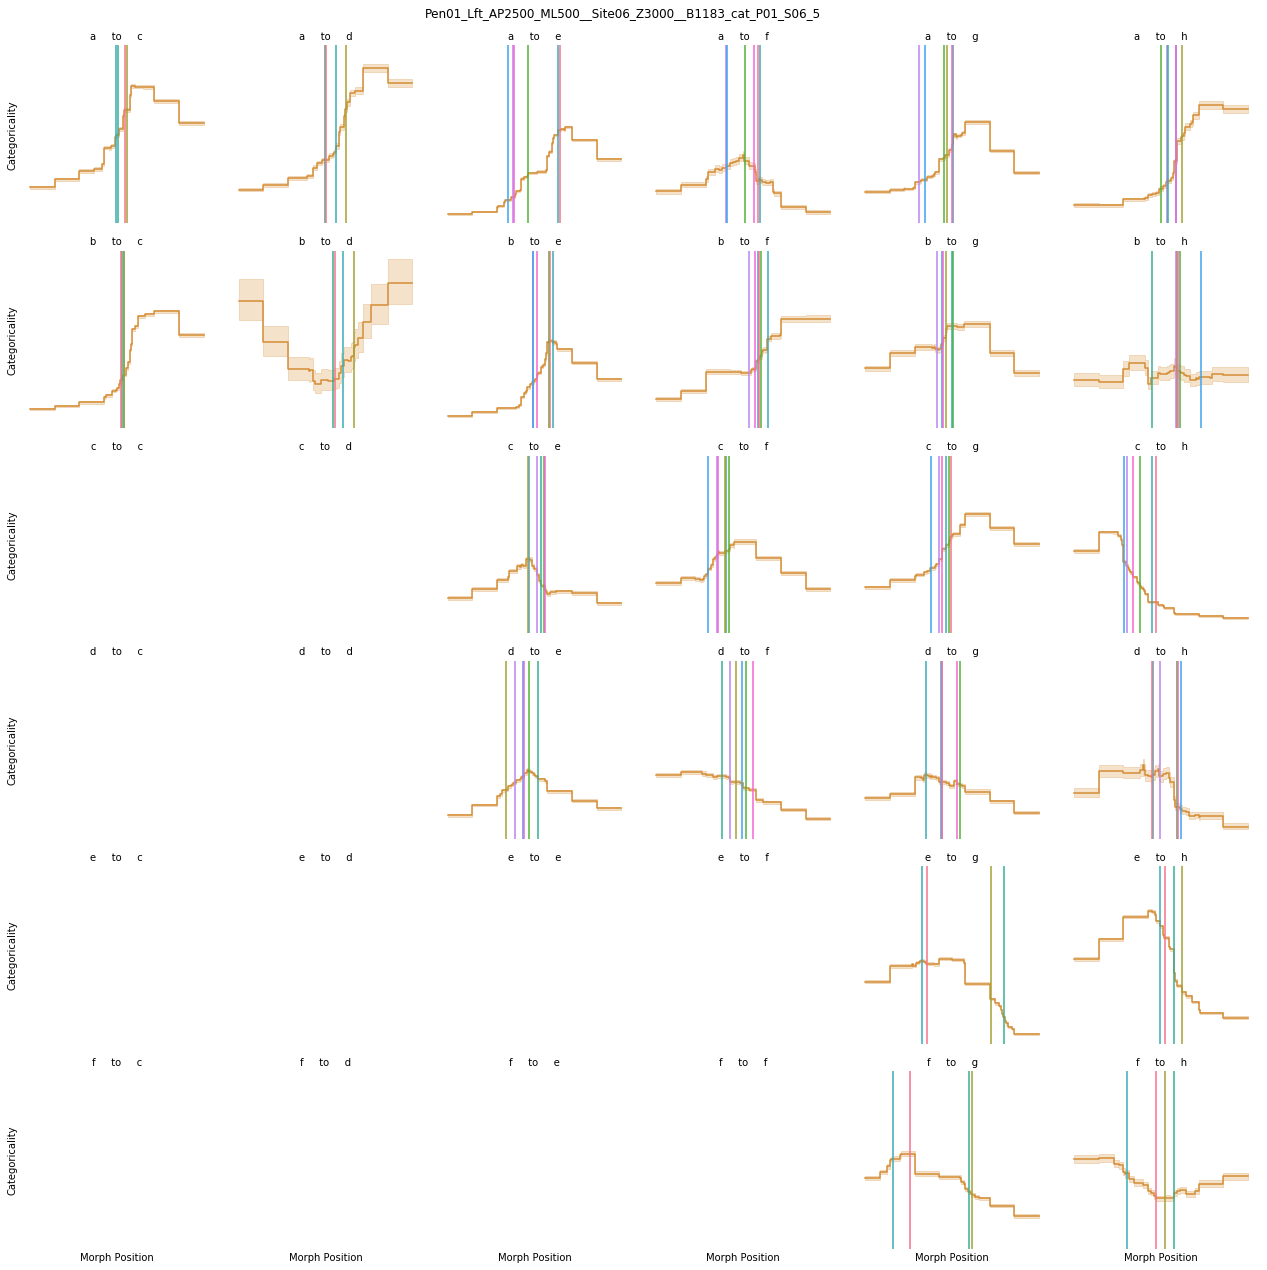

In [10]:
for i, (block_path, block_group) in enumerate(cat_df.groupby("block_path")):
    if i % 10 == 0:
        g = cat_viz(block_group, title=morphs.data.parse.blockpath_name(block_path))

In [11]:
controlled_cat_df = pair_df.groupby(["block_path", "morph_dim"]).apply(
    categorical, spect_dist_control=True
)

In [12]:
controlled_cat_df = controlled_cat_df.to_frame().reset_index()
morphs.data.parse.morph_dim(controlled_cat_df)
controlled_cat_df["bird_id"] = controlled_cat_df["block_path"].map(
    morphs.data.parse.bird_id
)
controlled_cat_df["equal_spacing"] = controlled_cat_df["block_path"].map(equal_spacing)

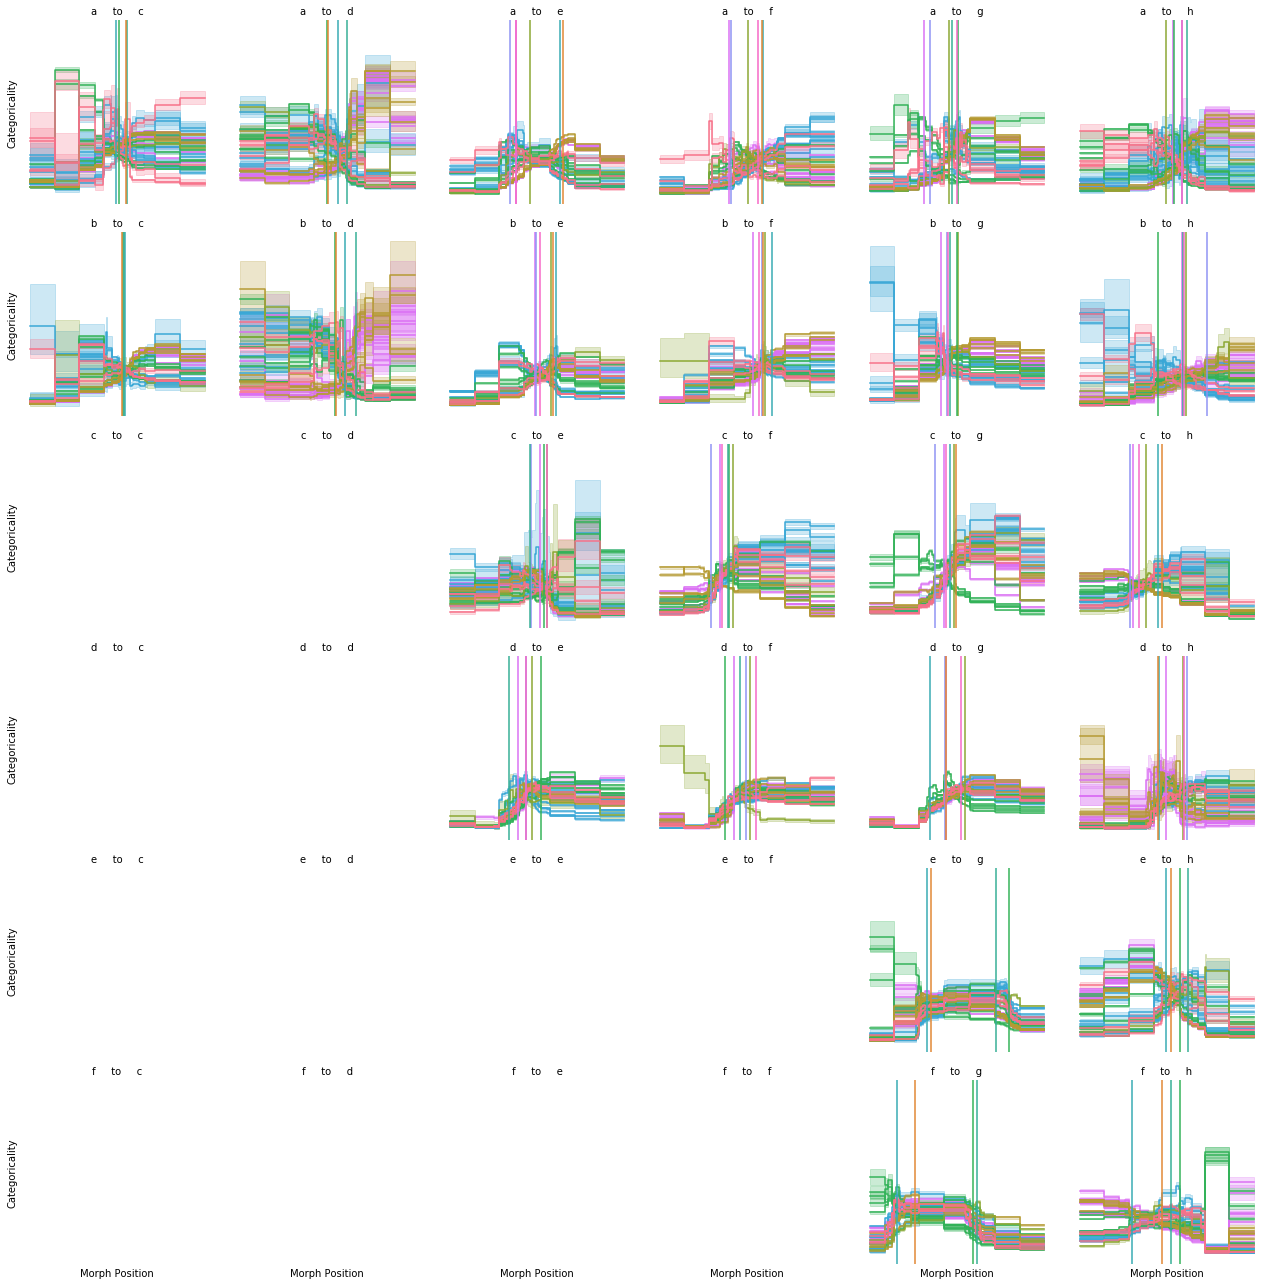

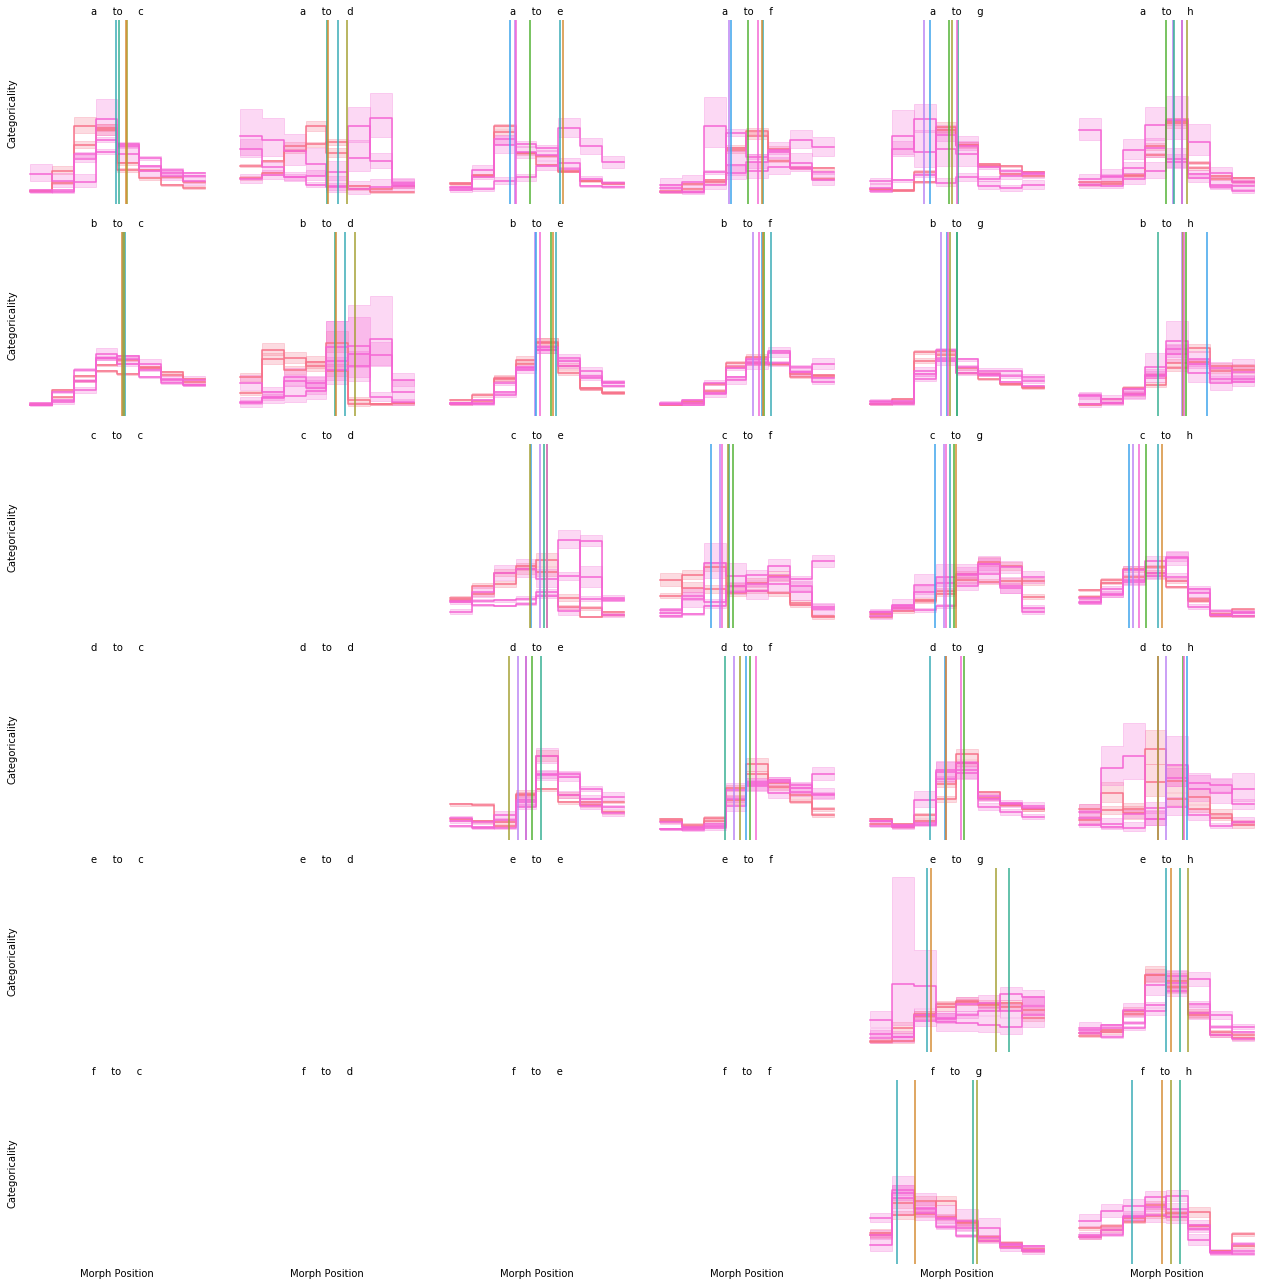

In [13]:
for spacing, spacing_group in controlled_cat_df.groupby("equal_spacing"):
    g = cat_viz(spacing_group)

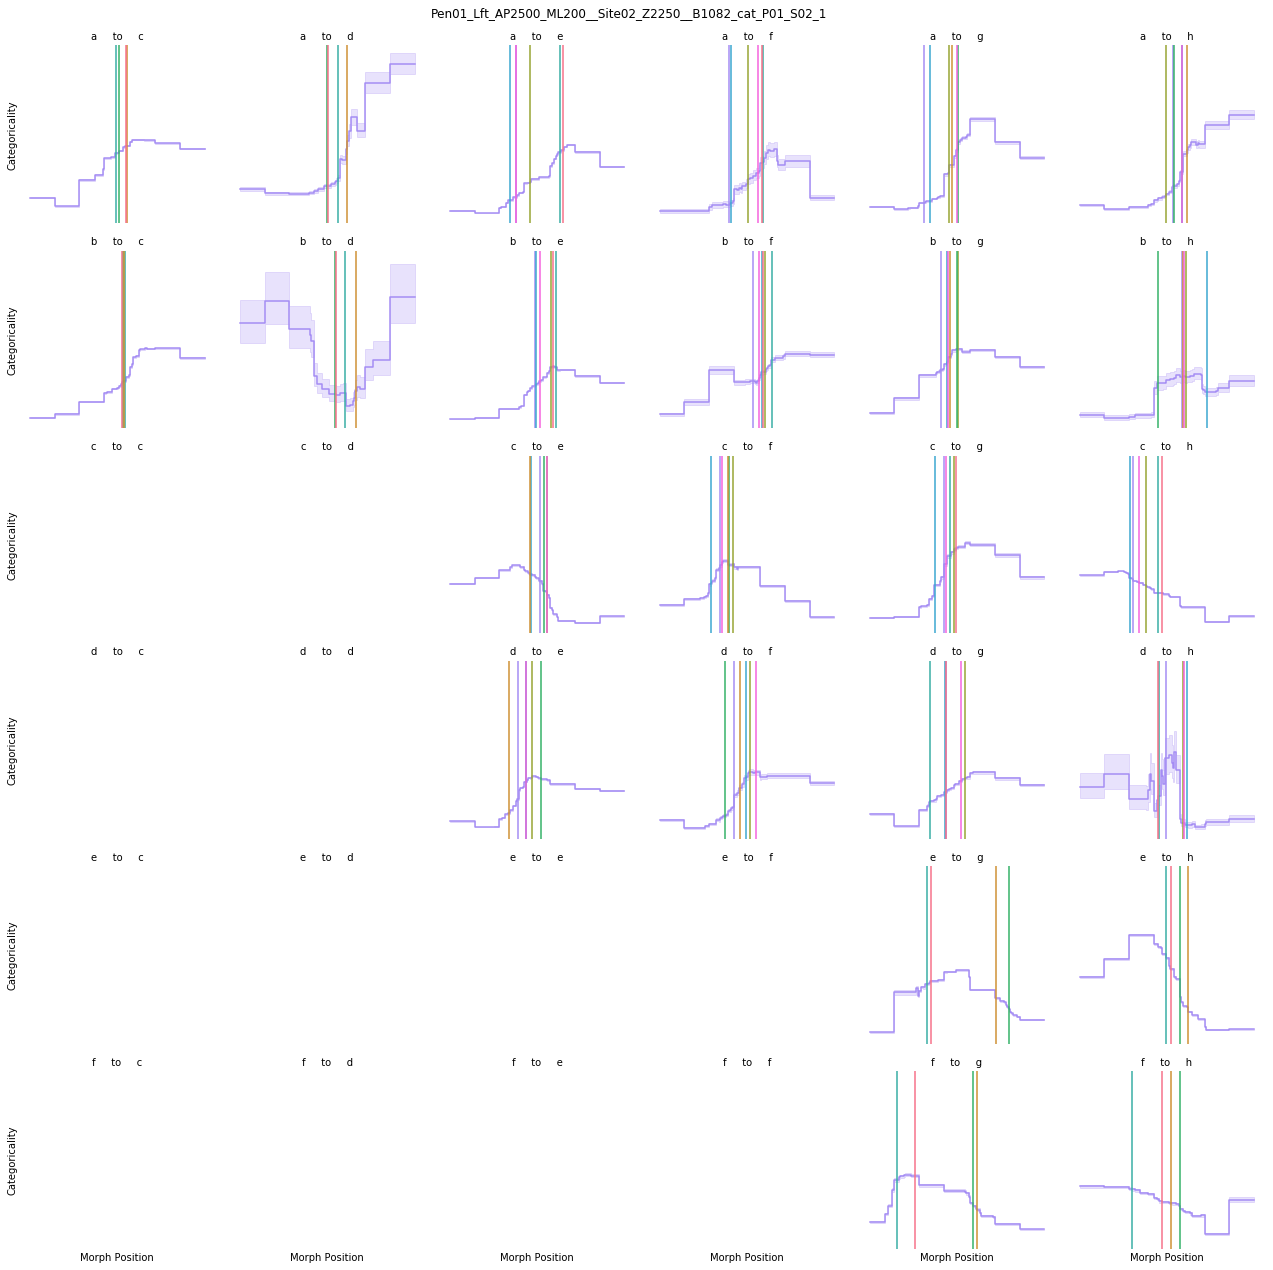

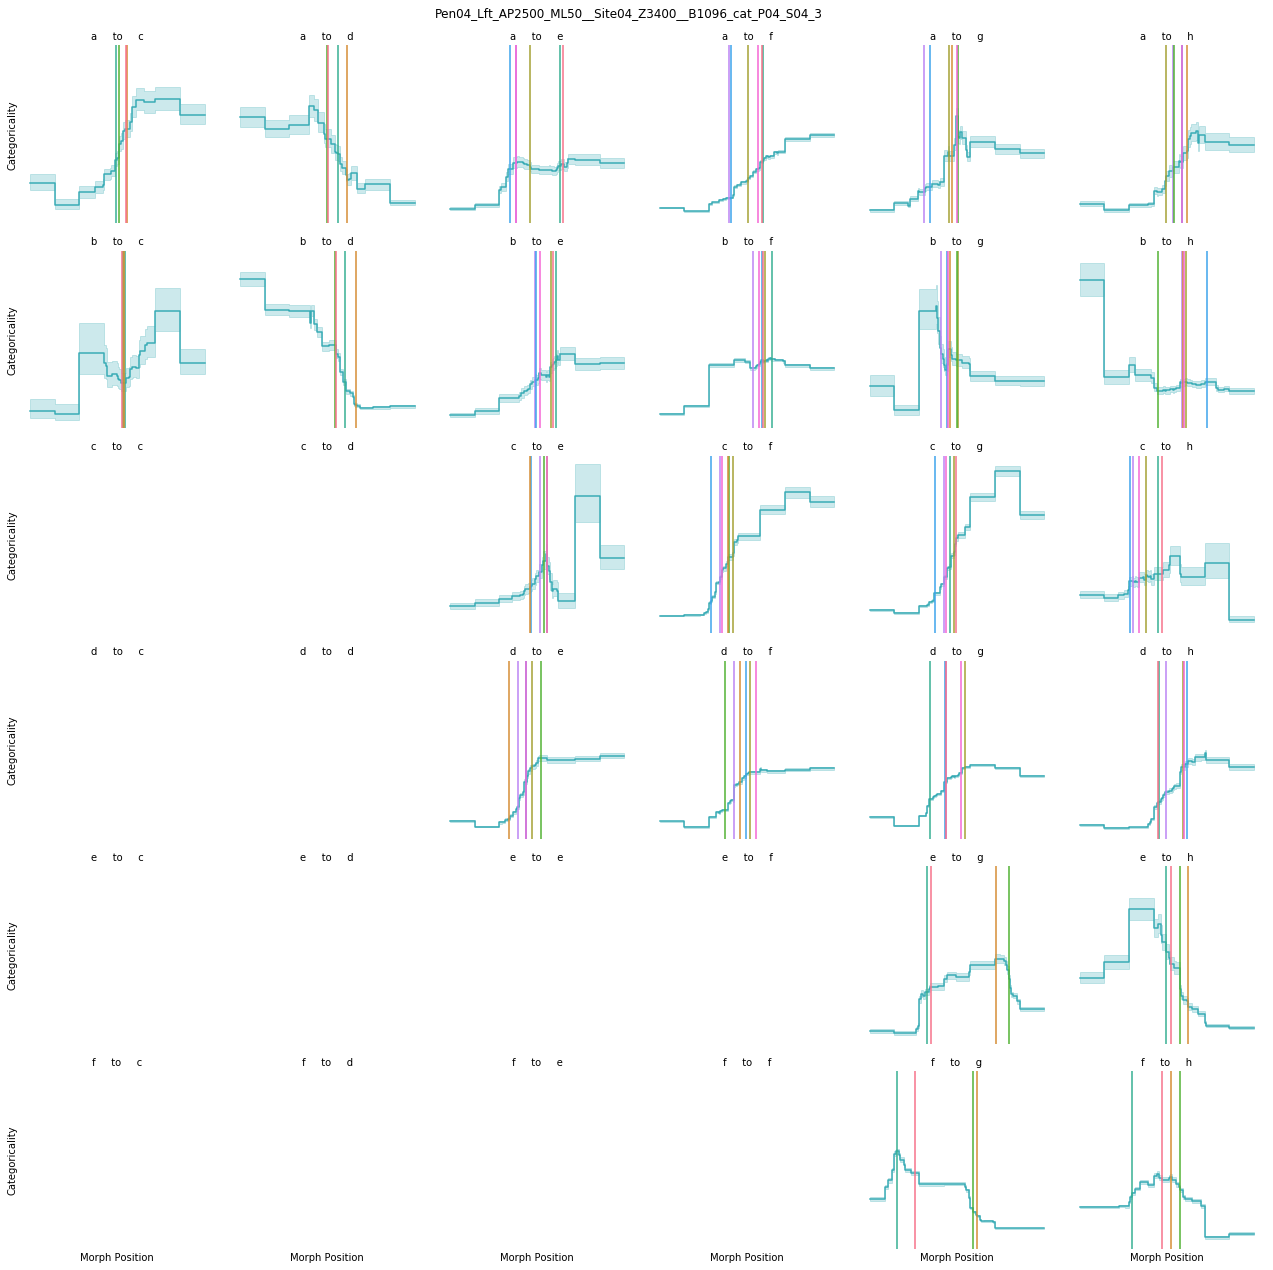

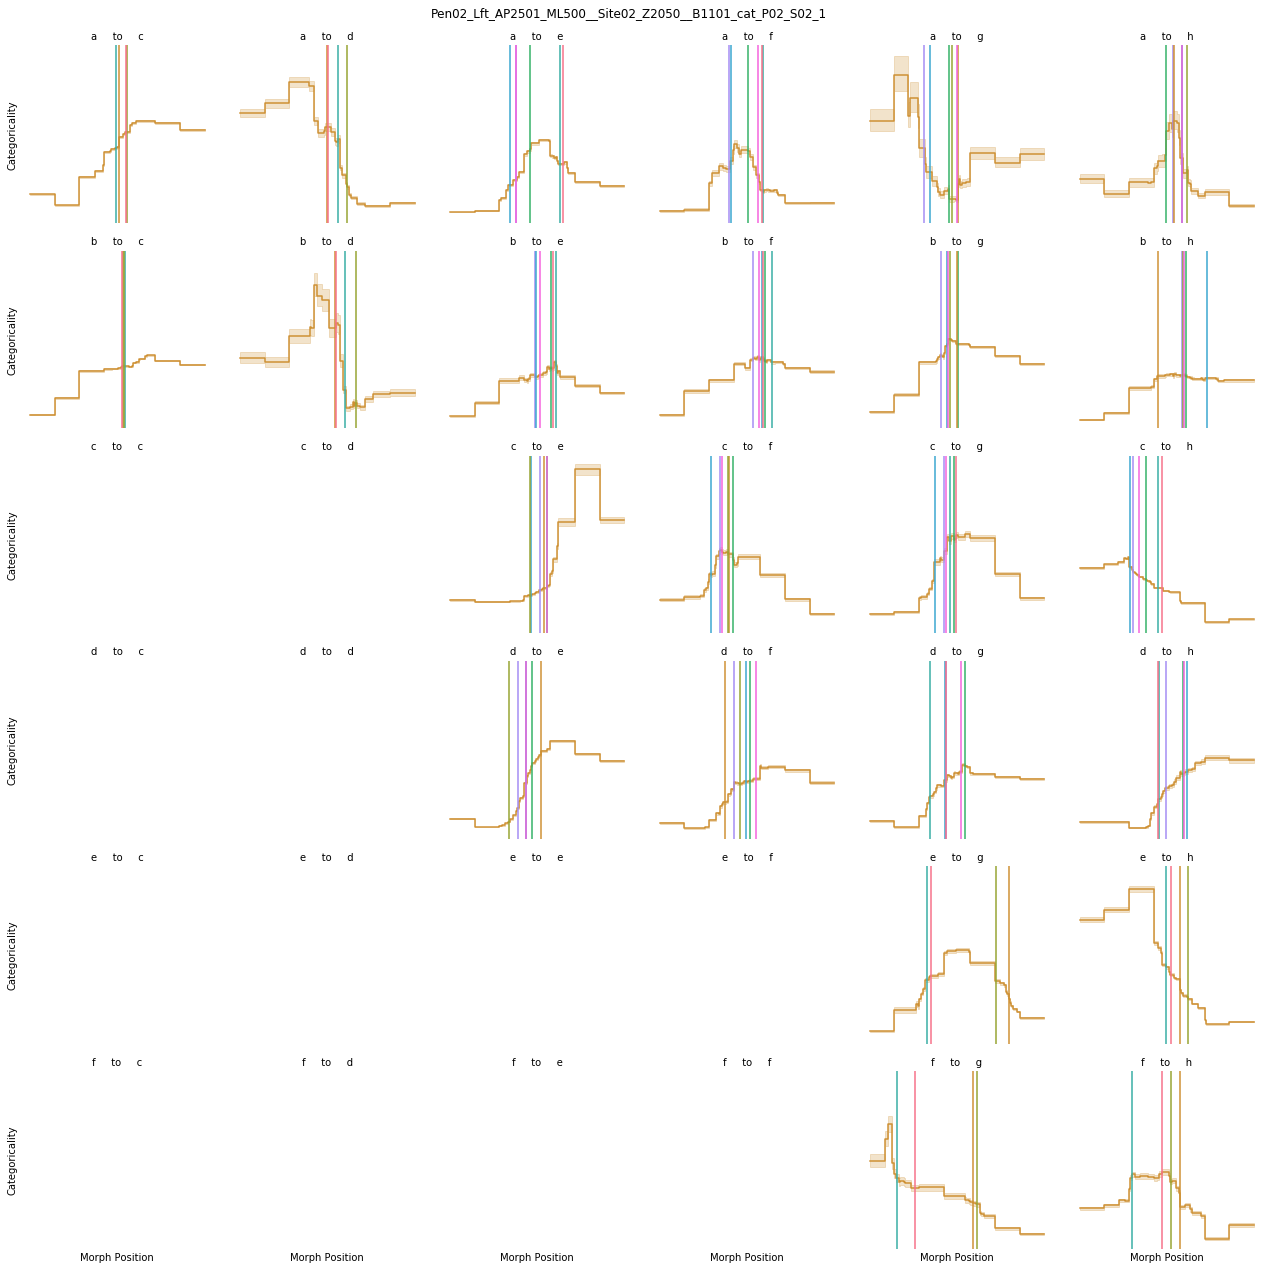

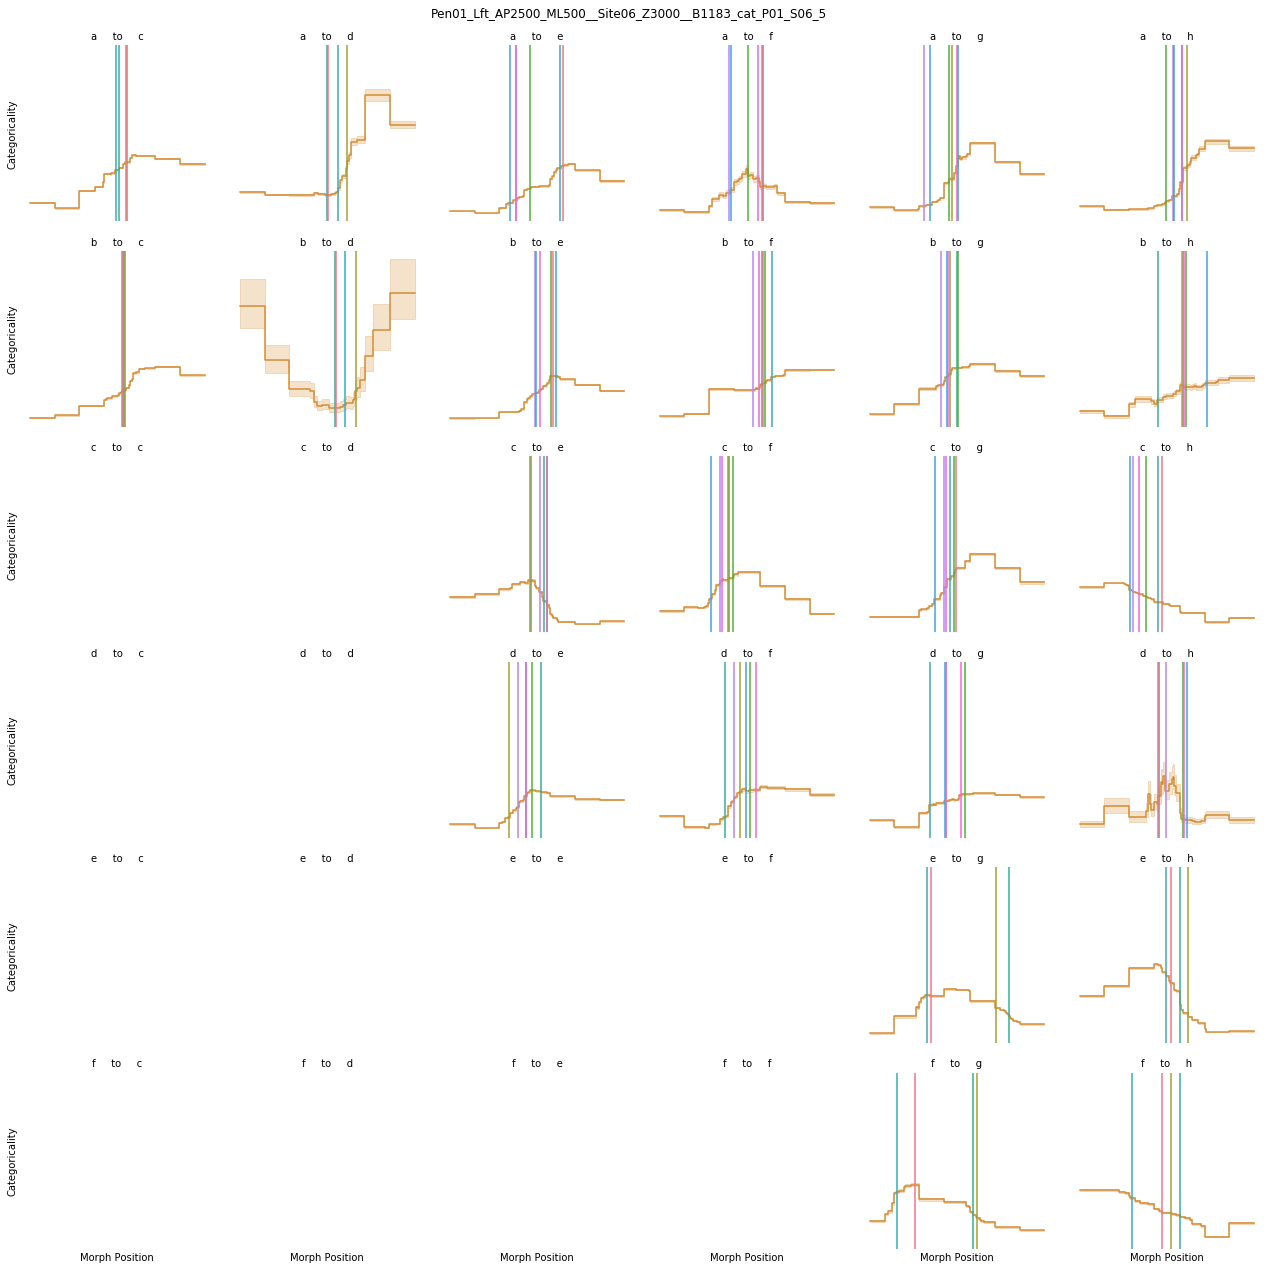

In [14]:
for i, (block_path, block_group) in enumerate(controlled_cat_df.groupby("block_path")):
    if i % 10 == 0:
        g = cat_viz(block_group, title=morphs.data.parse.blockpath_name(block_path))